In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Get the gradient response for a gradient waveform (g, [mT/m]) and the GSTF (H)
def get_response(g, H, pad_zeros=True, return_padded=False):
    """Convolves gradient waveform (g) with the GSTF (H) in the frequency domain.
    
    Parameters
    ----------
    g : array_like
        The input gradient waveform to be convolved (after FFT to frequency space) [mT/m]
    H : array_like
        The GSTF to be applied in the frequency domain.
    pad_zeros : bool, optional
        If True, pads g with zeros to match the size of H.
        Default is True.
    return_padded : bool, optional
        If True, returns the padded version of g.
        Default is False.
    """
    if g.size < H.size and pad_zeros:
        N_pad = H.size - g.size
        pad_before = int(N_pad * 0.1)
        pad_after = N_pad - pad_before
        g = np.pad(g, (pad_before, pad_after), mode='constant')
    
    g_freq = np.fft.fftshift(np.fft.fft(g))
    g_freq_response = g_freq*H
    g_prime = np.real(np.fft.ifft(np.fft.ifftshift(g_freq_response)))
    
    if pad_zeros and not return_padded:
        g_prime = g_prime[pad_before:-pad_after]

    return g_prime

In [3]:
# Load the measured GSTF
npz = np.load('./example_GIRF.npz')
Hz0 = npz['Hz0']  # GSTF z->0
Hzz = npz['Hzz']  # GSTF z->z

M1 Initial = -8.09e-09 T·s²/m
VENC Initial = 145.15 cm/s


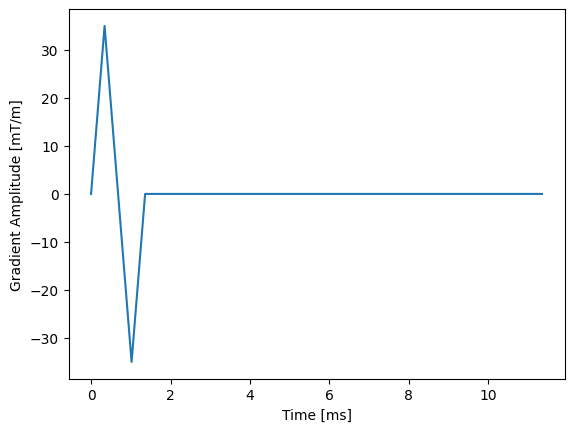

In [ ]:
# Design a simple bipolar
dt = 10e-6  # [s]
gmax = 35e-3  # [T/m]
smax = 100  # [T/m/s]
gamma = 2*np.pi*42.57e6   # Gyromagnetic ratio [rad/s/T]

# Make bipolar gradient [T/m]
g_bipolar = np.hstack([
                np.linspace(0,  gmax, int(gmax / smax / dt ))[:-1],
                np.linspace( gmax, 0, int(gmax / smax / dt ))[:-1],
                np.linspace(0, -gmax, int(gmax / smax / dt ))[:-1],
                np.linspace(-gmax, 0, int(gmax / smax / dt )),
                ])

# Zeropad after by 10ms
t_pad = 10e-3  # Padding time [s]
N_bipolar = g_bipolar.size
N_zeropad = int(t_pad / dt)
g_bipolar = np.hstack([g_bipolar, np.zeros(N_zeropad)])  # [T/m]

# Time vector for current g_bipolar
time = np.arange(len(g_bipolar)) * dt  # [s]

# Check the M1 and VENC
M1 = np.sum(g_bipolar * time) * dt     # [T•s^2/m]
venc_mps = np.pi / (gamma * np.abs(M1))  # VENC [m/s]
print(f"M1 Initial = {M1:.2e} T·s²/m")
print(f"VENC Initial = {100*venc_mps:.2f} cm/s")

plt.figure()
plt.plot(1000*time, 1000*g_bipolar)
plt.xlabel('Time [ms]')
plt.ylabel('Gradient Amplitude [mT/m]');

Text(0, 0.5, 'Gradient [mT/m]')

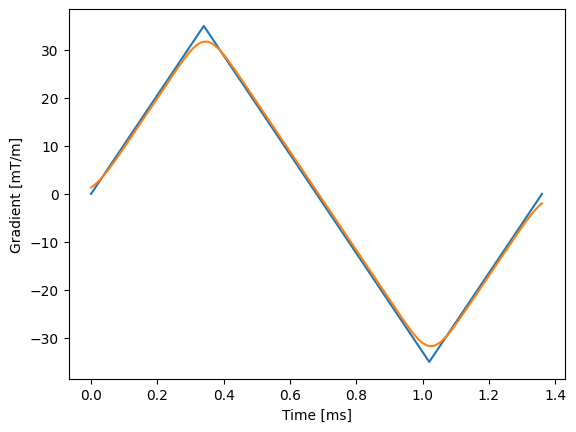

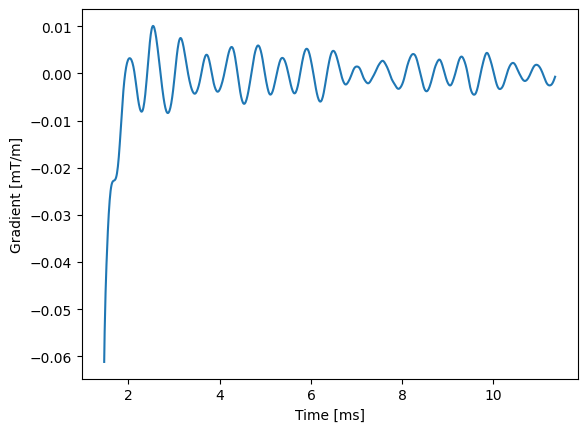

In [ ]:
gg_pred = get_response(1000 * g_bipolar, Hzz)  # Units are [mT/m] for input and output

# Plot the predicted bipolar
# NOTE: This is overly smoothed as smoother GIRFS work better for background prediction
#        I will try to update with a better GIRF for this application.

t_bipolar = np.arange(N_bipolar) * dt  # Time vector [s]
t_aft_bipolar = t_pred = np.arange(len(gg_pred[N_bipolar + 10:])) * dt + (N_bipolar + 10) * dt  # Time vector [s]

plt.figure()
plt.plot(1000*t_bipolar, 1000*g_bipolar[:N_bipolar])  # Plot in [ms] and [mT/m]
plt.plot(1000*t_bipolar, gg_pred[:N_bipolar])         # Plot in [ms] and [mT/m]
plt.xlabel('Time [ms]')
plt.ylabel('Gradient [mT/m]')

# Plot the prediction after the bipolar
plt.figure()
plt.plot(1000*t_aft_bipolar, gg_pred[N_bipolar+10:])   # Plot in [ms] and [mT/m]
plt.xlabel('Time [ms]')
plt.ylabel('Gradient [mT/m]')

Text(0, 0.5, 'B0 [mT]')

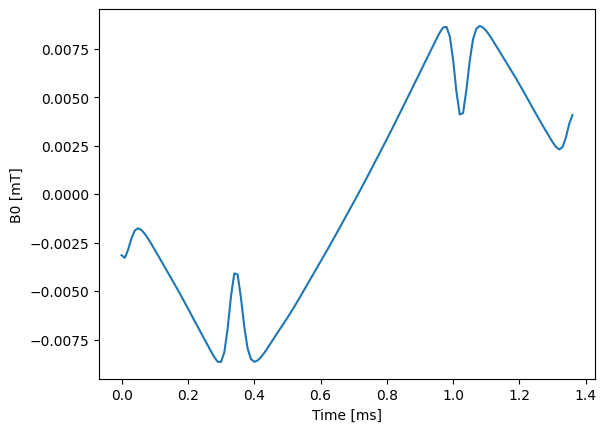

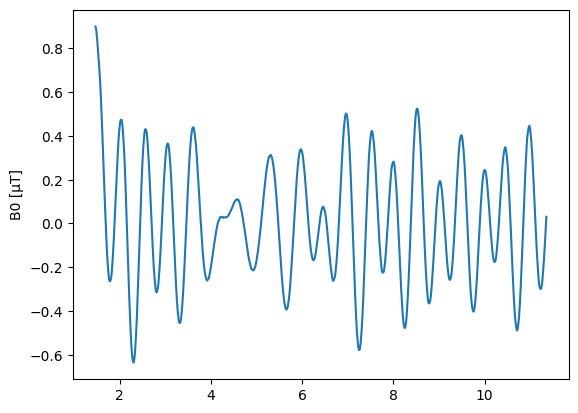

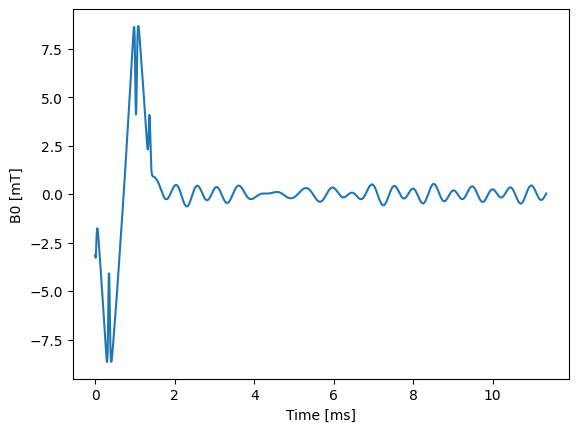

In [ ]:
# Same as last cell except using the GTF z->0
gg_pred = get_response(1000*g_bipolar, Hz0)  # Units are [mT/m] for input and output

t_bipolar = np.arange(N_bipolar) * dt  # Time vector [s]
t_aft_bipolar = t_pred = np.arange(len(gg_pred[N_bipolar + 10:])) * dt + (N_bipolar + 10) * dt  # Time vector [s]
t_gg_pred = np.arange(len(gg_pred)) * dt  # Time vector [s]

# Plot the prediction during the bipolar
plt.figure()
plt.plot(1000*t_bipolar, gg_pred[:N_bipolar])  # Plot in [ms] and [mT/m]
plt.xlabel('Time [ms]')
plt.ylabel('B0 [mT]')

# Plot the prediction after the bipolar
plt.figure()
plt.plot(1000*t_aft_bipolar, 1000*gg_pred[N_bipolar+10:])
plt.ylabel('B0 [µT]')

plt.figure()
plt.plot(1000*t_gg_pred, 1000*gg_pred)  # Plot in [ms] and [mT/m]
plt.xlabel('Time [ms]')
plt.ylabel('B0 [mT]')
